# <center> Predictive modelling with timeseries</center>
# <center> Part 4 - Time series forecasting with Facebook's Prophet</center>

![Image](images/timeseries.jpg)

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# jupyter lab configs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
plotly.offline.init_notebook_mode(connected=True)

from utils import print_errors
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly, add_changepoints_to_plot

# Exercise: Cryptocurrency value prediction

# ETL

### Load the datasets

In [4]:
bc = pd.read_csv('datasets/crypto.csv', decimal=".").reset_index(drop=True)
bc.Date = pd.to_datetime(bc.Date)
bc.sort_values('Date', inplace=True)
bc.head()
"min max date"
bc.Date.min(), bc.Date.max() 
"min max price"
bc.Price.min(), bc.Price.max() 

,Date,Price,Open,High,Low
0,2012-12-24,13.4,13.3,13.4,13.2
1,2012-12-25,13.4,13.4,13.4,13.1
2,2012-12-26,13.5,13.4,13.5,13.2
3,2012-12-27,13.4,13.5,13.5,13.3
4,2012-12-28,13.4,13.4,13.6,13.3


'min max date'

(Timestamp('2012-12-24 00:00:00'), Timestamp('2021-01-24 00:00:00'))

'min max price'

(13.3, 40599.3)

In [5]:
bc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2954 entries, 0 to 2953
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2954 non-null   datetime64[ns]
 1   Price   2954 non-null   float64       
 2   Open    2954 non-null   float64       
 3   High    2954 non-null   float64       
 4   Low     2954 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 138.5 KB


### `NOTE` the Prophet requires that datetime is named `ds` and the target is named `y`

In [14]:
bc.rename(columns={'Date': 'ds', 'Price': 'y'}, inplace=True)

### Train-test

In [15]:
# Let's train until 2019 and test on 2020
# split 
X_train = bc[bc.ds<='2019-12-31'][['ds', 'y']]
X_test = bc[bc.ds>'2019-12-31'][['ds']]

### Let's fit using the default configuration

In [8]:
# fit
model = Prophet()
model.fit(X_train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -25.3975


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4954.27     0.0447666       2305.23           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5164.76     0.0669276       721.447           1           1      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5258.86    0.00296036       238.016           1           1      346   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5299.16     0.0127275       252.832           1           1      475   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5315.71   0.000690549       99.7286       0.269       0.269      605   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599     

In [9]:
# check the predictions for the training data
pred_train = model.predict(X_train)

# use the trained model to make a forecast
pred_test = model.predict(X_test)

In [10]:
# check the model's output
pred_test.head(4)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-01,8911.092870,7649.070424,10679.371677,8911.092870,8911.092870,241.578193,241.578193,241.578193,-0.490939,-0.490939,-0.490939,242.069132,242.069132,242.069132,0.0,0.0,0.0,9152.671063
1,2020-01-02,8918.590109,7705.091249,10601.408414,8918.590109,8918.590109,220.341300,220.341300,220.341300,-11.433453,-11.433453,-11.433453,231.774753,231.774753,231.774753,0.0,0.0,0.0,9138.931409
2,2020-01-03,8926.087348,7607.427023,10745.054655,8926.087348,8926.087348,219.915284,219.915284,219.915284,-1.929811,-1.929811,-1.929811,221.845095,221.845095,221.845095,0.0,0.0,0.0,9146.002632
3,2020-01-04,8933.584588,7630.091964,10625.833541,8933.584588,8933.584588,219.933752,219.933752,219.933752,7.722355,7.722355,7.722355,212.211396,212.211396,212.211396,0.0,0.0,0.0,9153.518339


yhat: is the predicted value for that date in the row,

trend: telling that from yhat, how much is coming from trend

addictive and multiplicative: ???

## Plot predictions - test dataset

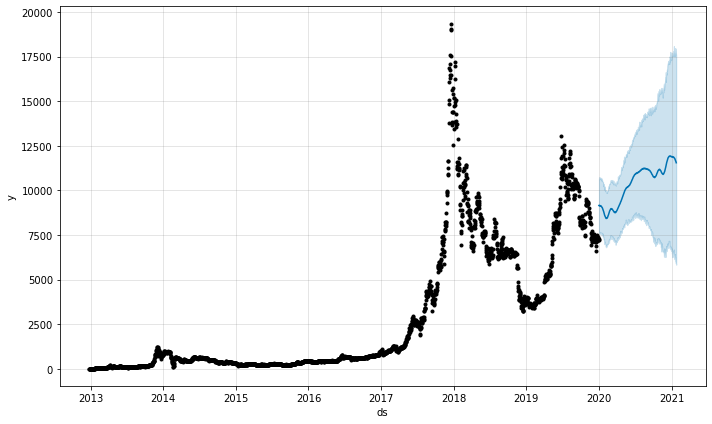

In [11]:
# plot forecast
p = model.plot(pred_test)

## Plot predictions - training dataset

In [12]:
plot_plotly(model, pred_train)

In [13]:
plot_components_plotly(model, pred_train)

# 🤩 Perfecting the model

# 1. Add events and holidays  

One of the advantages of the Prophet is the ability to add covariates to specific dates. They can be given by you or taken *out-of-the-box* by using the package `holidays`.
For a user-specified input, event dates must be profived for past and future, and we should make a dataframe with the following format: 

In [21]:
user_events = pd.DataFrame({
  'holiday': ['something_amazing', 'crash', 'something_amazing', 'something_amazing'],
  'ds': pd.to_datetime(['2017-12-17', '2018-12-16', '2019-06-26', '2020-11-15']),
  'lower_window': -2,
  'upper_window': 2})

In [24]:
user_events

,holiday,ds,lower_window,upper_window
0,something_amazing,2017-12-17,-2,2
1,crash,2018-12-16,-2,2
2,something_amazing,2019-06-26,-2,2
3,something_amazing,2020-11-15,-2,2


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -25.3975


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5168.91      0.179356       450.872           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5367.08     0.0259286       259.826           1           1      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5438.69    0.00204299       679.367      0.1998      0.9085      353   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5458.42     0.0123448       277.611           1           1      470   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5483.48   0.000788023       178.017      0.3463      0.3463      590   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     508     

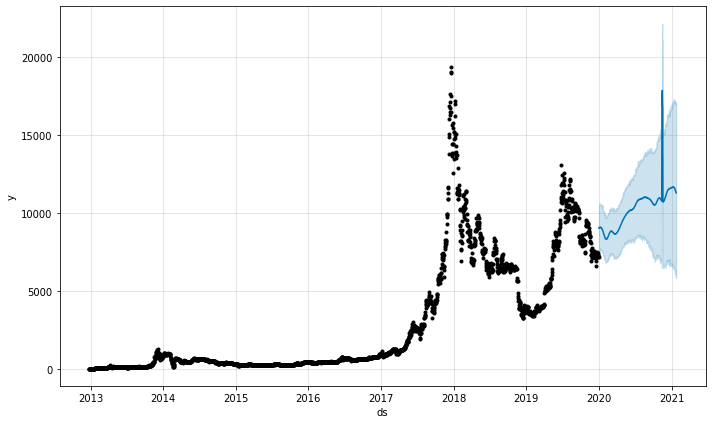

In [25]:
m3 = Prophet(holidays=user_events)
m3.fit(X_train)
pred_train = m3.predict(X_train)
pred_test = m3.predict(X_test)
fig = m3.plot(pred_test)

### Add calendar holidays

In [26]:
m4 = Prophet()
m4.add_country_holidays(country_name='DE')
m4.fit(X_train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -25.3975
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4957.13     0.0100927       614.303           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5182.31     0.0062841       319.671           1           1      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5264.66     0.0353839       261.848        0.54        0.54      354   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5323.92     0.0284805       412.692           1           1      469   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5339.76    0.00025776       119.625     0.05271      0.7438      581   
    Iter      log prob        ||dx||      ||grad||       alpha  

In [27]:
# check holidays included
m4.train_holiday_names

0                      Neujahr
1                   Karfreitag
2                  Ostermontag
3                   Erster Mai
4          Christi Himmelfahrt
5                Pfingstmontag
6    Tag der Deutschen Einheit
7         Erster Weihnachtstag
8        Zweiter Weihnachtstag
9              Reformationstag
dtype: object

# 2. Configuring the TREND 

## 1. Changepoints

Prophet will use 80% of the data (by default) to identify points where the trend changed abruptly.
We can change this value, but care must be taken as increasing it may lead to overfitting and extreme changes in the nearest predictions.


### 80% changepoints

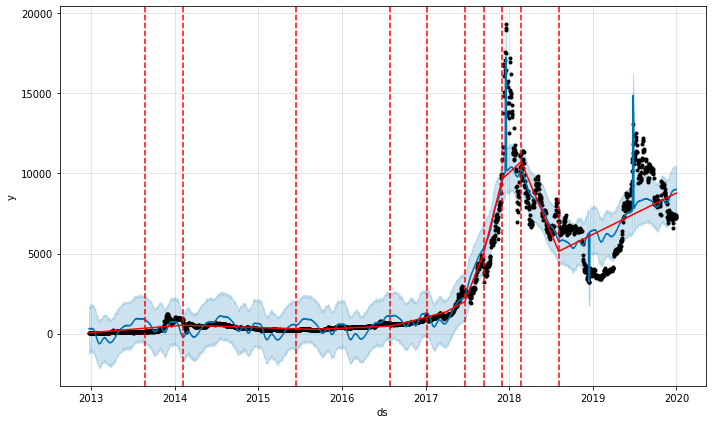

In [28]:
fig = model.plot(pred_train)
a = add_changepoints_to_plot(fig.gca(), model, pred_train)

### 90% changepoints

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -25.3975


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5256.89      0.107878       1366.27           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5449.16    0.00354802       910.256       0.209           1      227   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5499.05     0.0862358       465.505           1           1      347   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     376       5555.86   0.000410846        512.12   6.564e-07       0.001      484  LS failed, Hessian reset 
     399       5581.35     0.0198454        141.34           1           1      510   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        5634.4     0.0259187       812.515      0.5099           1      6

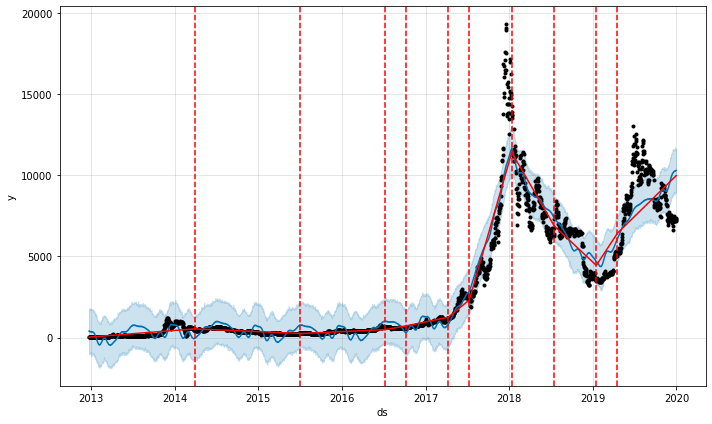

In [29]:
m9 = Prophet(changepoint_range=0.9)
m9.fit(X_train)
pred_train = m9.predict(X_train)
pred_test = m9.predict(X_test)
fig = m9.plot(pred_train)
a = add_changepoints_to_plot(fig.gca(), m9, pred_train)

### Manually inserting changepoints

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -25.3975


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      22       4116.71   0.000330096      0.734257           1           1       29   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


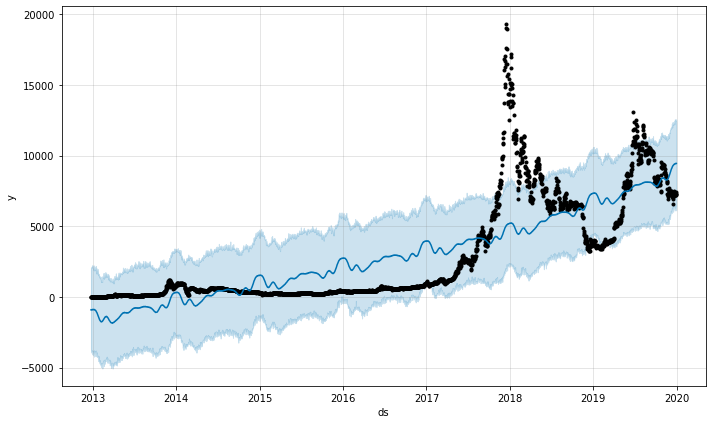

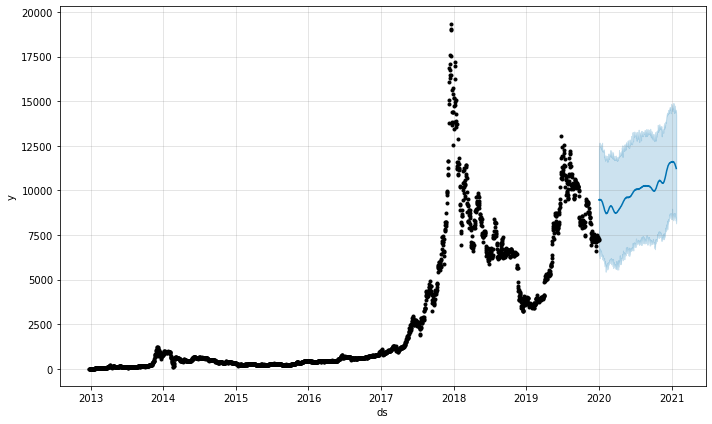

In [30]:
m2 = Prophet(changepoints=['2017-12-16'])
m2.fit(X_train)
pred_train = m2.predict(X_train)
pred_test = m2.predict(X_test)
fig = m2.plot(pred_train)
fig = m2.plot(pred_test)

### Can you try adding more changepoints? What happens?

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -25.3975


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      29       4434.68   1.69189e-05      0.587554      0.5483      0.5483       38   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


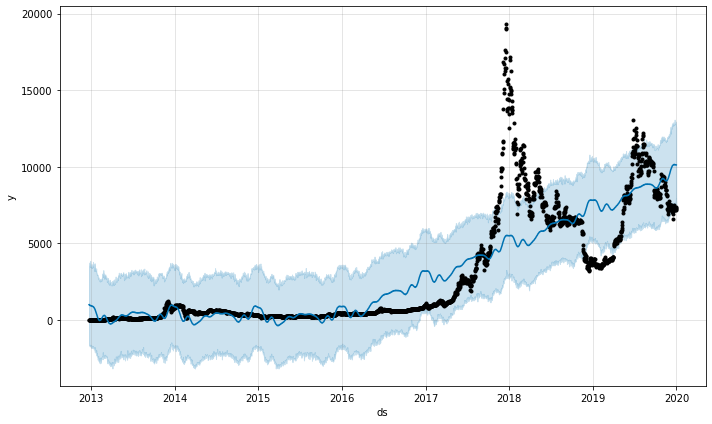

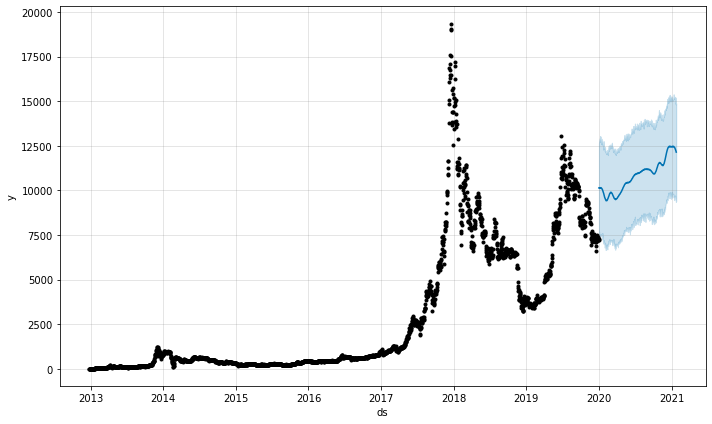

In [31]:
m2 = Prophet(changepoints=['2015-12-16'])
m2.fit(X_train)
pred_train = m2.predict(X_train)
pred_test = m2.predict(X_test)
fig = m2.plot(pred_train)
fig = m2.plot(pred_test)

### 2. Adjusting trend scale

The paramater `changepoint_prior_scale` helps to control over/underfitting. Default of model is 0.5

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -25.3975


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        5202.5     0.0846632       863.183       0.676       0.676      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5584.55    0.00901281       170.777           1           1      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5811.73      0.131133       2627.74           1           1      344   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        5936.8      0.047123       749.714           1           1      453   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       6099.05    0.00343828        581.69       0.567       0.567      562   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599     

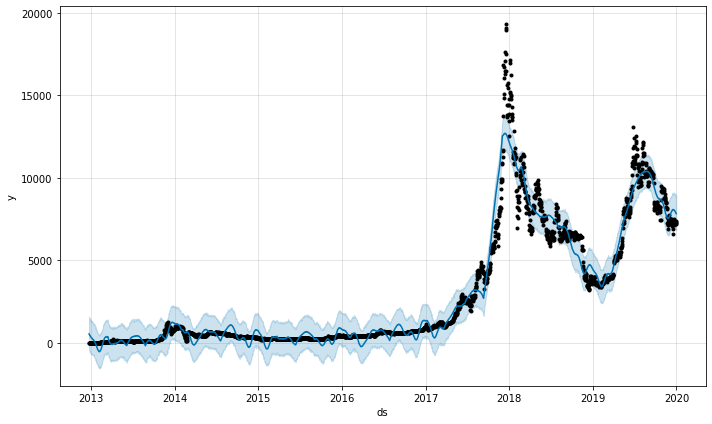

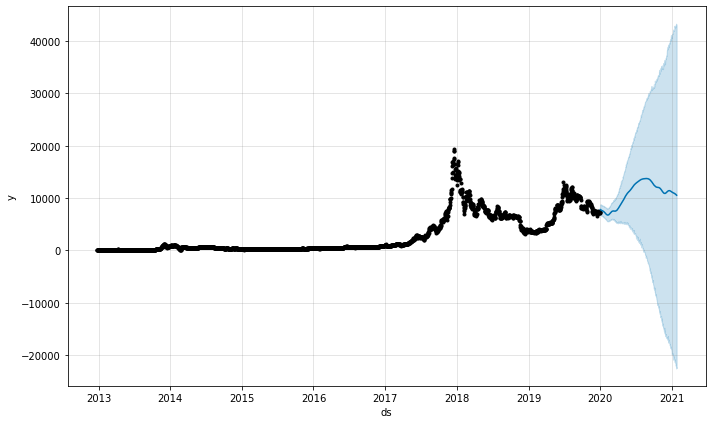

In [34]:
m1 = Prophet(changepoint_prior_scale=0.8)
m1.fit(X_train)
pred_train = m1.predict(X_train)
pred_test = m1.predict(X_test)
fig = m1.plot(pred_train)
fig = m1.plot(pred_test)

# 3. Configuring the seasonality

The parameter `yearly.seasonality` let's you adjust the Fourier order that models the yearly seasonality.  
The default is 10. Increasing it leads to increased model complexity, because N fourier terms corresponds to 2N variables used for modeling the cycle. Decreasing it leads to a smoother curve.

In [35]:
m7 = Prophet(yearly_seasonality=12, weekly_seasonality=6)

**Specifying seasonalities**  

By default the Prophet will by default fit **weekly** and **yearly** seasonalities, if the time series is more than two cycles long.  
It will also fit daily seasonality for a sub-daily time series.  
You can add other seasonalities (monthly, quarterly, hourly) using the `add_seasonality` method:  

In [36]:
# in this example we disable weekly seasonality and add a monthly instead
m6 = Prophet(weekly_seasonality=False)
m6.add_seasonality(name='monthly', period=30.5, fourier_order=5)

# 4. Add regressors 

what if we had more information about other factor that could have influenced the day-to-day trade of bitcoin?
Maybe some daily economy indicator or market conditions. Any information like this would be a timeseries itself, and it can increase the model's performance. The downside is, we need to have the data available for the future. 
If we have more series to add to the dataset, they are called **regressors**.

In [37]:
# Add new timeseries to the dataset and then include them in the model

# Example of usage
X_train['new_regressor'] = 2 # should be a real timeseries data

m7 = Prophet()
m7.add_regressor('new_regressor')
m7.fit(X_train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -25.3975
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4875.88     0.0386281       954.807           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5167.83     0.0420075       969.743      0.9716      0.9716      226   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5250.71     0.0225281       1995.32      0.6968      0.6968      339   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5292.89      0.021766        668.34           1           1      457   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     483       5319.98    0.00013903       191.883   2.639e-07       0.001      591  LS failed, Hessian reset 
     499       5322.93    0.00164894    

# HOMEWORK

Cover the topics **hyperparameter tuning**, **gridsearch**, **cross-validation** and **model evaluation**.
Prophet has built-in methods for all these steps. You can start checking here: https://facebook.github.io/prophet/docs/diagnostics.html 


---

<a href='https://www.freepik.com/vectors/business'>Business vector created by freepik - www.freepik.com</a>